# Data Cleaning

In this notebook we focus on removing or fixing null values. We also convert categorical data so it is really to be processed by scikitlearn.

# Load the data

In [1]:
import os

project_root = os.path.join(os.getcwd(), os.pardir)
raw_data_dir = os.path.join(project_root, 'data', 'raw')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train_df = pd.read_csv(os.path.join(raw_data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(raw_data_dir, 'test.csv'))

# Fix null values

Age and Cabin both have missing values...

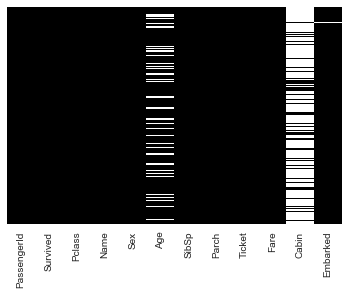

In [4]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='cubehelix')

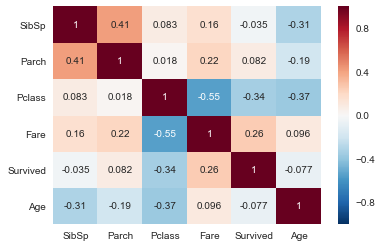

In [5]:
# Pclass here might not be important as data is categorical

sns.heatmap(train_df[['SibSp', 'Parch', 'Pclass', 'Fare', 'Survived', 'Age']].corr(),annot=True)

# Linear regression model to impute age

We combine the train and test data to obtain more data to impute the age from.

In [6]:
# combine train and test data for more data to impute age
both_df = pd.concat([train_df, test_df])

sex = pd.get_dummies(both_df['Sex'], drop_first=True)
embark = pd.get_dummies(both_df['Embarked'], drop_first=True)
pclass = pd.get_dummies(both_df['Pclass'], drop_first=True)

age_df = pd.concat([
        sex, 
        embark, 
        pclass, 
        both_df['SibSp'], 
        both_df['Parch'], 
        both_df['Fare'],
        both_df['Age']
    ], 
    axis=1
)

In [7]:
age_df.dropna(inplace=True)

In [8]:
age_df.columns

Index(['male', 'Q', 'S', 2, 3, 'SibSp', 'Parch', 'Fare', 'Age'], dtype='object')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = age_df[['male', 'Q', 'S', 2, 3, 'SibSp', 'Parch', 'Fare']]
y = age_df['Age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [10]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
print(lm.intercept_)

38.829628972


In [12]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
male,2.259048
Q,3.825153
S,1.775212
2,-11.279900
3,-15.660779
SibSp,-3.082110
Parch,-0.581395
Fare,0.002841


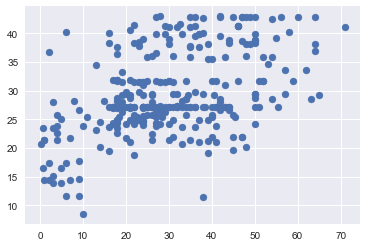

In [13]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

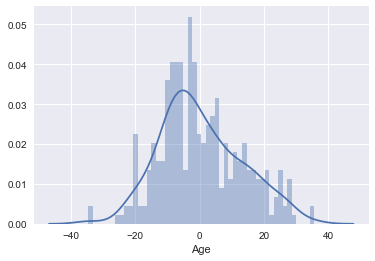

In [14]:
sns.distplot((y_test-predictions),bins=50);

In [15]:
from sklearn import metrics
import numpy as np

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 10.2850655062
MSE: 162.914707572
RMSE: 12.7638045884


In [16]:
max(predictions)

42.997716930864961

In [17]:
min(predictions)

8.5039814961933082

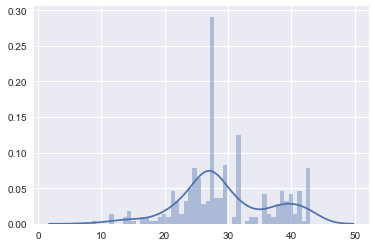

In [18]:
sns.distplot(predictions, bins=50)

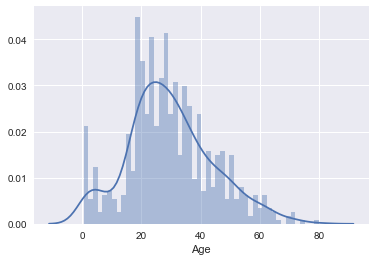

In [19]:
sns.distplot(train_df['Age'].dropna(), bins=50)

**Distribution of missing age and pclass**

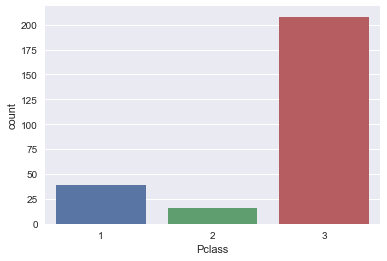

In [20]:
sns.countplot(both_df[both_df['Age'].isnull()]['Pclass'])

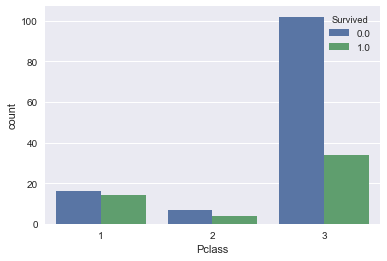

In [21]:
nulls_df = both_df[both_df['Age'].isnull()]
sns.countplot(x='Pclass', hue='Survived', data=nulls_df)

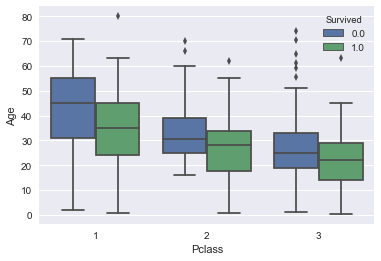

In [22]:
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=both_df)

# Clean train and test dfs with our new model

In [23]:
# First clean the dataframe by removing categories etc..

def clean_df(df):
    sex = pd.get_dummies(df['Sex'], drop_first=True)
    embark = pd.get_dummies(df['Embarked'], drop_first=True)
    pclass = pd.get_dummies(df['Pclass'], drop_first=True)
    
    df = pd.concat([df, sex, embark, pclass], axis=1)
    df = df.drop(['Sex', 'Embarked', 'Pclass', 'Cabin'], axis=1)
    return df

In [24]:
clean_train_df = clean_df(train_df)
clean_test_df = clean_df(test_df)

In [25]:
from math import floor

impute_age_cols = ['male', 'Q', 'S', 2, 3, 'SibSp', 'Parch', 'Fare', 'Age']

def impute_age(cols):
    age = cols[-1]
    X = cols.drop(cols.index[-1])    
    X = X.values.reshape(1, -1)
    
    new_age = age
    if pd.isnull(age):
        new_age = floor(lm.predict(X))
        
    return new_age

In [26]:
clean_train_df['Age'] = clean_train_df[impute_age_cols].apply(impute_age, axis=1)

In [27]:
clean_test_df['Age'] = clean_test_df[impute_age_cols].apply(impute_age, axis=1)

# Save datasets

In [28]:
clean_data_dir = os.path.join(project_root, 'data', 'clean')

In [29]:
clean_train_df.to_csv(os.path.join(clean_data_dir, 'train.csv'), index=False)

In [30]:
clean_test_df.to_csv(os.path.join(clean_data_dir, 'test.csv'), index=False)